# 6.5 Lab 1: Subset Selection Methods

## 6.5.1 Best Subset Selection

In [153]:
"""This notebook contains the code for best subset selection, 
so this notebook may take longer time to run, for faster run, make
max_feature into a smaller number"""
max_feature = 3
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import time
import random
import itertools

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler

In [154]:
Hitters = pd.read_csv('data/Hitters.csv', header=0, na_values='NA')

print list(Hitters) # get the header of this data

print Hitters.shape # get the dimension of this 

Hitters.head() # pull a sample of this dataset

['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague']
(322, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [155]:
print np.sum(pd.isnull(Hitters['Salary'])) # number of NAs in Salary column'
print Hitters['Salary'].isnull().sum()

Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
Hitters.shape

print Hitters['Salary'].isnull().sum()

59
59
0


In [156]:
y = Hitters.Salary  # the response variable 

"""
take care of the features 
1. change category into dummy variables 
2. Choose (n-1) dummy variable into the feature set: n is the unique values of each categorical variable.
"""

dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
print dummies.head()

X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
0         0         1           0           1            0            1
1         1         0           0           1            1            0
2         0         1           1           0            0            1
3         0         1           1           0            0            1
4         1         0           0           1            1            0


In [157]:
"""
Since in Python there is no well-defined function for best subset selection, 
we will need to define some functions ourselves.
1. Define a function to run on a subset of feature and extract RSS
2. Select the best model (models) for a fix number of features
"""
def getRSS(y, X, feature_list):
    model = sm.OLS(y, X[list(feature_list)]).fit()
    RSS = ((model.predict(X[list(feature_list)]) - y) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel(y, X, K):
    results = []
    for c in itertools.combinations(X.columns, K):
        results.append(getRSS(y, X, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].argmin()] ## this could be modified to have the top several models
    return best_model

In [158]:
models = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):  # for illustration purpuse, I just run for 1 - max_fearure features 
    models.loc[i] = bestModel(y, X, i)
    
print models.loc[2, 'Model'].summary() 
# this summay confirms that the best two variable model contains the variables Hits and CRBI

/Users/xqiuping/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     416.7
Date:                Thu, 23 Aug 2018   Prob (F-statistic):           5.80e-82
Time:                        17:02:34   Log-Likelihood:                -1907.6
No. Observations:                 263   AIC:                             3819.
Df Residuals:                     261   BIC:                             3826.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           2.9538      0.261     11.335      0.0

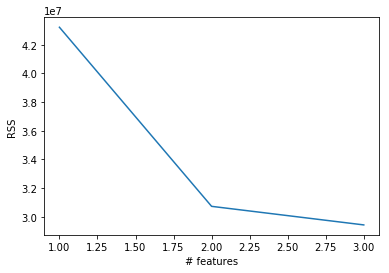

In [159]:
""" this show an example to plot the RSS of best models with different number of parameters"""
plt.figure()
plt.plot(models["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [160]:
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1) # find the adjust R^2, use dir() to identify all available attributes

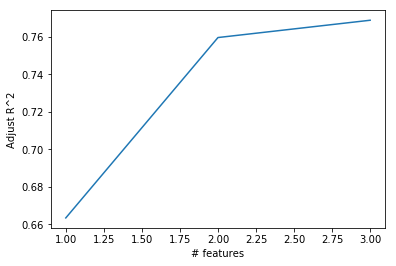

In [161]:
"""
The following graph shows the adj R^2 is still increasing, 
in this case, it is a good idea trying models with more features. 
"""
plt.figure()
plt.plot(rsquared_adj)
plt.xlabel('# features')
plt.ylabel('Adjust R^2')
plt.show()

## 6.5.2 Forward and Backward Stepwise Selection

### Forward Stepwise Selection

In [162]:
"""
We can use the previous user defined function 'def getRSS(y, X, feature_list)' to add 1 feature at a time (start from 0 feature) for forward stepwise selection
or delete 1 feature at a time(start from all the features) for backward stepwise selection. 
"""
def forward_select(y, X, feature_list):
    remaining_predictors = [p for p in X.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS(y, X, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model  

In [163]:
models2 = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward_select(y, X, feature_list)
    feature_list = models2.loc[i]["Model"].model.exog_names

/Users/xqiuping/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  if sys.path[0] == '':


In [164]:
"""we can compare the results of best subset selection and the forward selection"""
print('Best max_feature variable from best subset selection on tranining')
print models.loc[max_feature, 'Model'].params
print('\n---------------------------------------------')
print('Best max_feature variable from forward selection on tranining')
print models2.loc[max_feature, 'Model'].params

Best max_feature variable from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64


### Backward Stepwise Selection

In [165]:
def backward_select(y, X, feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS(y, X, combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model  

In [166]:
"""
The backward selection starts from all the variables of features
"""
models3 = pd.DataFrame(columns=["RSS", "Model"], index = range(1,len(X.columns)))
feature_list = X.columns

while(len(feature_list) > 1):
    models3.loc[len(feature_list)-1] = backward_select(y, X, feature_list)
    feature_list = models3.loc[len(feature_list)-1]["Model"].model.exog_names

print models3.loc[max_feature, "Model"].params

/Users/xqiuping/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  import sys


Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64


## 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

### In previous sections, we defined the 'best' model based on some statistics (R^2, adj R^2, AIC, BIC, etc) of the training dataset. This may cause 'overfitting' problemm which means the best model on training data can not generalize well to new data. In this section, validation approach will be discussed.

### Validation Set Approach and best subset selection / Validation Set Approach and forward selection

In [167]:
# Randomly split the data into traning dataset and validation dateset
np.random.seed(seed = 21)
train_index = np.random.choice([True, False], size = len(y), replace = True, p = [0.7, 0.3]) 
# random select ~70% of data into traning sample
# the rest of the samples will be in testing set.
test_index = np.invert(train_index)
X_train= X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

In [168]:
""" We can recyle the old functions. Modification is needed to compute the RSS for the testing data. 
So we need to add both train and test into the function input (Implement)
-OR-: we can wrap the train and test split step into the function(Not Implemented)
"""
def getRSS_validation(y_train, X_train, y_test, X_test,  feature_list):
    model = sm.OLS(y_train, X_train[list(feature_list)]).fit()
    RSS = ((model.predict(X_test[list(feature_list)]) - y_test) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel_validation(y_train, X_train, y_test, X_test, K):
    results = []
    for c in itertools.combinations(X_train.columns, K):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].argmin()] ## this could be modified to have the top several models
    return best_model


def forward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    remaining_predictors = [p for p in X_train.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model

def backward_select_validation(y_train, X_train, y_test, X_test,  feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test,  combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].argmin()]
    return best_model  

In [169]:
models_validation = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):  # for illustration purpuse, I just run for 1 - max_fearure features 
    models_validation.loc[i] = bestModel_validation(y_train, X_train, y_test, X_test, i) 
    
    
"""change the function to  forward_select_validation (.) or backward_select_validation(.) 
for forward selection or backward selection""" 
    
models2_forward = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2_forward.loc[i] = forward_select_validation(y_train, X_train, y_test, X_test,  feature_list)
    feature_list = models2_forward.loc[i]["Model"].model.exog_names    


/Users/xqiuping/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  app.launch_new_instance()
/Users/xqiuping/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


In [170]:
print('Best max_feature variable from best subset selection on tranining')
print models.loc[max_feature, 'Model'].params
print('\n---------------------------------------------')
print('Best max_feature variable from forward selection on tranining')
print models2.loc[max_feature, 'Model'].params
print('\n---------------------------------------------')
print('Best max_feature variable from backward selection on tranining')
print models3.loc[max_feature, 'Model'].params
print('\n---------------------------------------------')
print('Best max_feature variable from best subset selection on traning and validation split')
print models_validation.loc[max_feature, 'Model'].params

Best max_feature variable from best subset selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from forward selection on tranining
Hits       2.316407
CRBI       0.666517
PutOuts    0.261395
dtype: float64

---------------------------------------------
Best max_feature variable from backward selection on tranining
Hits       2.111712
CRuns      0.646149
PutOuts    0.295625
dtype: float64

---------------------------------------------
Best max_feature variable from best subset selection on traning and validation split
Hits       2.591880
CHmRun     2.675775
PutOuts    0.210471
dtype: float64


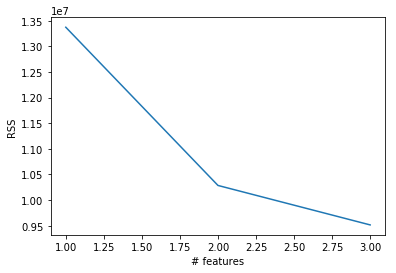

In [171]:
""" this show an example to plot the RSS of best models with different number of parameters for best subset with validation"""
plt.figure()
plt.plot(models_validation["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

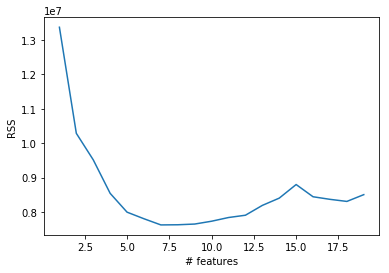

' From above graph, that 6 variables model gives us the best RSS under forward selection. \nTo learn the final model, it is also recommendated to re-train the model on entire data (train + validation). '

In [172]:
""" this show an example to plot the RSS of best models with different number of parameters for forward selection with validation"""
plt.figure()
plt.plot(models2_forward["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()
""" From above graph, that 6 variables model gives us the best RSS under forward selection. 
To learn the final model, it is also recommendated to re-train the model on entire data (train + validation). """

### Cross-Validation

In [173]:
"""This approach is similar to the previous validation idea. 
The difference is that we break the entire dataset into K different folds. 
Each run, the model will be trained on all the data from K-1 folds and tested on the remaining fold.
Advantages: 
1. There will be multiple metrics out of testing results => distribution of testing RSS, etc
2. The size of traning dataset is much closer to the size of original dateset. This will remove some biases caused by
the size difference."""

k = 10
np.random.seed(seed = 21)
train_index = np.random.choice(k, size = len(y), replace = True)  # Randomly assign each observations into folds
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,len(X.columns) + 1))

In [174]:
models_cv = pd.DataFrame(columns=["RSS", "Model"])
for j in range(1,k+1):
    feature_list = []
    for i in range(1,len(X.columns)+1):
        models_cv.loc[i] = forward_select_validation(y[train_index!= (j-1)], X[train_index != (j-1)], 
                                                     y[train_index == (j-1)],X[train_index == (j-1)], 
                                                     feature_list)
        
        cv_errors[j][i] = models_cv.loc[i]["RSS"]
        feature_list = models_cv.loc[i]["Model"].model.exog_names

/Users/xqiuping/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


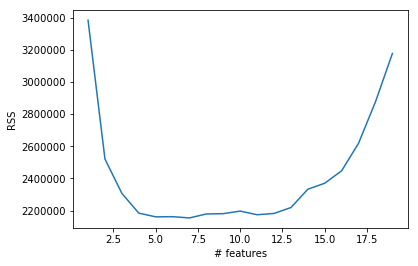

In [175]:
cv_errors_mean = cv_errors.mean(axis = 1)
plt.figure()
plt.plot(cv_errors_mean)
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

In [176]:
"""From the above plot, we can see that the model with 5 variables yielded the smallest RSS.
We can take a closer look at that model summary. 
We can also see that the model performance for variables 4 - 12 are similar."""
print(models_cv.loc[5, "Model"].summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     155.0
Date:                Thu, 23 Aug 2018   Prob (F-statistic):           1.40e-71
Time:                        17:02:44   Log-Likelihood:                -1704.1
No. Observations:                 235   AIC:                             3418.
Df Residuals:                     230   BIC:                             3435.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Walks          6.3470      0.934      6.795      0.0

# 6.6 Lab 2: Ridge Regression and the Lasso

### sklearn has the ridge and lasso functionality implemented. So here we import those submodules 

In [177]:
from sklearn.preprocessing import scale 
from sklearn import cross_validation
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

### similar to before, we need to prepare the features(indepedent) variables and response(depedent) varisble.

In [178]:
Hitters = pd.read_csv('data/Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])

y = Hitters.Salary  # the response variable 
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

## 6.6.1 Ridge Regression

### Next, we will generate a few canadidates lambda(in sklearn, the keyword is alphas) for our Ridge regression. In R, alpha is a switch for Ridge and Lasso methods.

In [179]:
alphas = 10**np.linspace(10,-2,100)
alphas

array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.84803587e+07, 2.15443469e+07, 1.62975083e+07,
       1.23284674e+07, 9.32603347e+06, 7.05480231e+06, 5.33669923e+06,
       4.03701726e+06, 3.05385551e+06, 2.31012970e+06, 1.74752840e+06,
       1.32194115e+06, 1.00000000e+06, 7.56463328e+05, 5.72236766e+05,
       4.32876128e+05, 3.27454916e+05, 2.47707636e+05, 1.87381742e+05,
       1.41747416e+05, 1.07226722e+05, 8.11130831e+04, 6.13590727e+04,
       4.64158883e+04, 3.51119173e+04, 2.65608778e+04, 2.00923300e+04,
       1.51991108e+04, 1.14975700e+04, 8.69749003e+03, 6.57933225e+03,
       4.97702356e+03, 3.76493581e+03, 2.84803587e+03, 2.15443469e+03,
      

### Associated with each value of alpha is a vector of ridge regression coefficients, stored in a matrix that can be accessed by coeffs. In this case, it is a 19×100, 19 is the dimension of the features + (intercept needs to call separately) and 100 is the len of the alphas. The result is a numpy series with len 100 and len(coffes[0]) is 19. In this specific implementation, the default is no intercept.  

In [180]:
ridge = Ridge(fit_intercept=True, normalize=True)
coeffs = []
intercepts = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coeffs.append(ridge.coef_)
    intercepts.append(ridge.intercept_)

In [181]:
print len(coeffs)
print len(coeffs[0])
print len(intercepts)
print intercepts[0] # try run print len(intercepts[0])

100
19
100
535.9258816915063


### As design, as alphas get bigger, magnitude of coefficients turn to be closer to zero. One thing to remember is that the decay is quite smooth

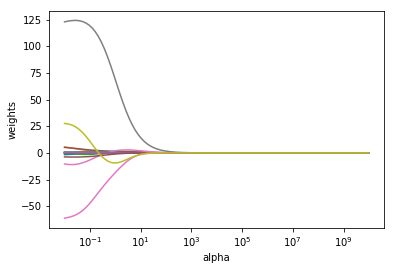

In [182]:
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log') # try without this line
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [183]:
print alphas[49]
print math.sqrt(sum(map(lambda x:x*x, coeffs[49]))) 
# We may notice the coefficients l2 norm is different from R output 
# I tried a few different normalization methods but still did not get the exact same output 

print coeffs[49]

11497.569953977356
0.0156040153647
[ 1.05084190e-04  3.81213219e-04  1.53587268e-03  6.44641457e-04
  6.80918080e-04  8.01446032e-04  3.27704404e-03  9.02214059e-06
  3.32048758e-05  2.50408429e-04  6.66164023e-05  6.87496444e-05
  7.27332307e-05  4.21005722e-05  6.87621309e-06 -3.21056660e-05
  1.11649125e-03  1.50775795e-02  2.19838773e-04]


### We now split the samples into a training set and a test set in order to estimate the test error of ridge regression and the lasso. Python provides a built-in function to produce training and test data set.

In [184]:
X_train, X_test , y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.66)

In [185]:
ridge = Ridge(fit_intercept=True, normalize=True, alpha=4)
ridge.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))        # Calculate the test MSE

AtBat           0.057770
Hits            0.280470
HmRun           1.696433
Runs            0.344180
RBI             0.777681
Walks           1.077091
Years           3.680301
CAtBat          0.009220
CHits           0.030704
CHmRun          0.534376
CRuns           0.066356
CRBI            0.103096
CWalks          0.086388
PutOuts         0.088005
Assists         0.036705
Errors          0.626791
League_A       -2.985694
Division_E     36.529828
NewLeague_A    -2.102978
dtype: float64
131344.74025856136


### To select best alpha, we will use cross validation. And as standard, we will report test set performance as the final performance metric

In [186]:
ridgecv =  RidgeCV(alphas, scoring='mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

/Users/xqiuping/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/xqiuping/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/xqiuping/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/xqiuping/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weig

0.6579332246575682

In [187]:
ridge_best = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge_best.fit(X_train, y_train)
mean_squared_error(y_test, ridge_best.predict(X_test))

132809.6101812174

### If we exam the values of the coefficients, most of them are tiny, but none of them is zero.

In [188]:
pd.Series(ridge_best.coef_, index=X.columns)

AtBat           -0.043690
Hits             0.290475
HmRun            2.307585
Runs             0.010003
RBI              1.197184
Walks            2.575096
Years            3.844652
CAtBat           0.009922
CHits            0.030502
CHmRun           1.165054
CRuns            0.079669
CRBI             0.181248
CWalks           0.088957
PutOuts          0.235423
Assists          0.146865
Errors           1.261345
League_A        -6.490527
Division_E     109.178051
NewLeague_A     -0.939364
dtype: float64

## 6.6.2 The Lasso

### We saw that ridge regression with a wise choice of λ can outperform least squares as well as the null model on the Hitters data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression.

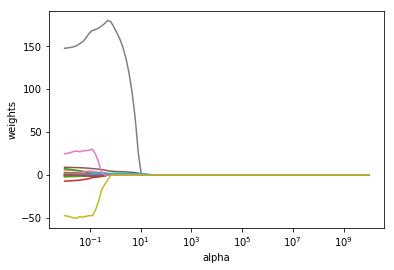

In [189]:
lasso= Lasso(normalize=True, max_iter=1e5) 
coeffs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coeffs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [190]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=1e5, normalize=True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

146392.2464445864

In [191]:
# Some of the coefficients should reduce to exact zero
pd.Series(lasso.coef_, index=X.columns)

AtBat           -0.000000
Hits             0.000000
HmRun            0.000000
Runs            -0.000000
RBI              0.000000
Walks            3.866781
Years            0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun           1.946302
CRuns            0.000000
CRBI             0.435854
CWalks           0.000000
PutOuts          0.321438
Assists          0.251371
Errors           0.000000
League_A        -0.000000
Division_E     151.322929
NewLeague_A     -0.000000
dtype: float64

-------------------------